In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

Original Historical Document Info:
 Dimensions: 251 x 411 x 3
 Data type: uint8
 Pixel Range (min, max): (28, 190)



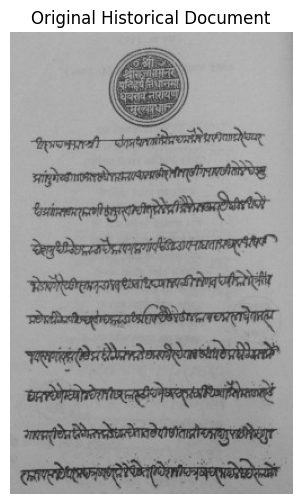

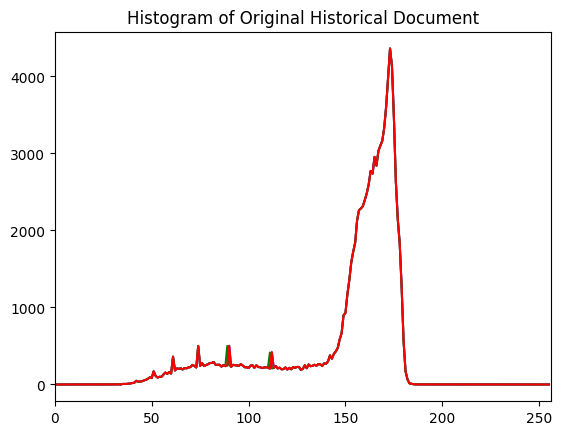

In [2]:
def load_document_image(path):
    image = cv2.imread(path)
    return image

def display_image_info(image, title="Original Image"):
    height, width, channels = image.shape
    print(f"{title} Info:")
    print(f" Dimensions: {width} x {height} x {channels}")
    print(f" Data type: {image.dtype}")
    print(f" Pixel Range (min, max): ({image.min()}, {image.max()})\n")
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()
    plt.figure()
    if channels == 3:
        color = ('b', 'g', 'r')
        for i, c in enumerate(color):
            hist = cv2.calcHist([image], [i], None, [256], [0, 256])
            plt.plot(hist, color=c)
            plt.xlim([0, 256])
    else:
        hist = cv2.calcHist([image], [0], None, [256], [0, 256])
        plt.plot(hist, color='black')
        plt.xlim([0, 256])
    plt.title(f"Histogram of {title}")
    plt.show()

path_to_image = "../archive/historical-doc.png"
doc_image = load_document_image(path_to_image)
display_image_info(doc_image, "Original Historical Document")


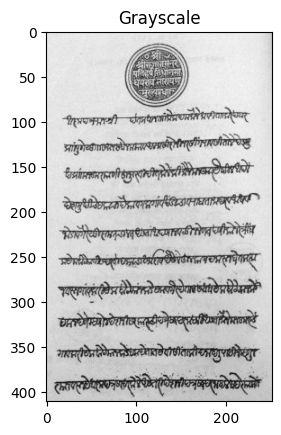

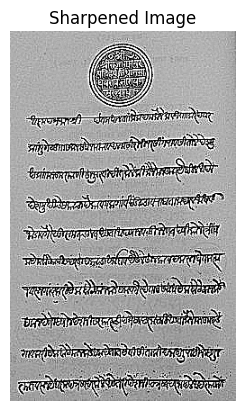

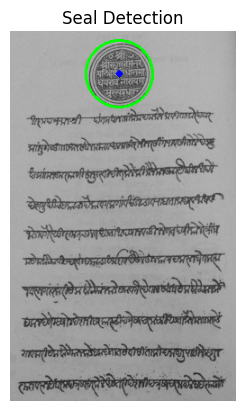

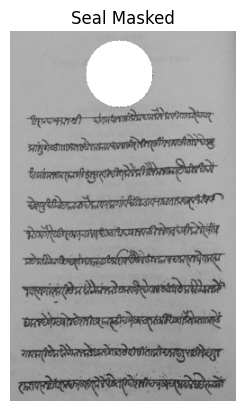

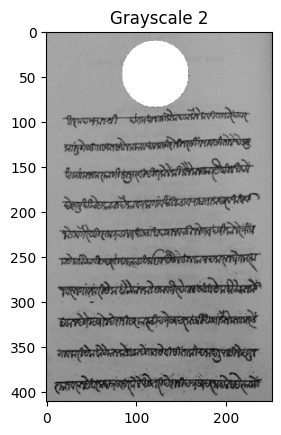

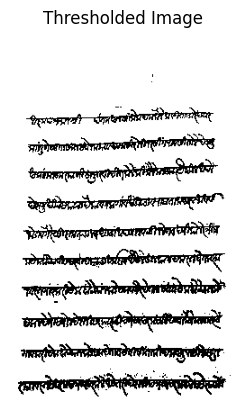

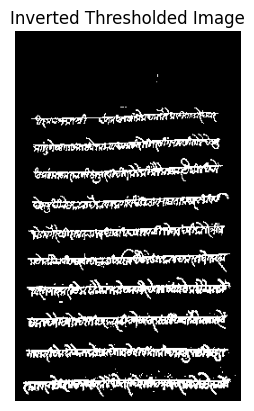

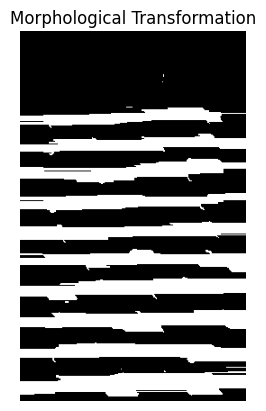

Seal at Center: (np.uint16(121), np.uint16(47)), Radius: 37


In [3]:
def preprocess_document_image(image):
    grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    plt.plot, plt.title("Grayscale"), plt.imshow(grayscale, cmap="gray")
    plt.show()
    kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
    sharpened = cv2.filter2D(grayscale, -1, kernel)
    plt.imshow(sharpened, cmap="gray")
    plt.title("Sharpened Image")
    plt.axis("off")
    plt.show()
    circles = cv2.HoughCircles(grayscale, cv2.HOUGH_GRADIENT, dp=1.2, minDist=1000, param1=50, param2=30, minRadius=35, maxRadius=50)
    output = image.copy()
    circles = np.uint16(np.around(circles))
    circle = circles[0, 0]
    center, radius = (circle[0], circle[1]), circle[2]
    cv2.circle(output, center, radius, (0, 255, 0), 2)  
    cv2.circle(output, center, 2, (255, 0, 0), 3)  
    seal = (center, radius)  
    plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB), cmap="gray")
    plt.title("Seal Detection")
    plt.axis("off")
    plt.show()

    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    cv2.circle(mask, center, radius, 255, -1)
    inverted_image = image.copy()
    inverted_image[mask == 255] = 255
    preprocess = cv2.cvtColor(inverted_image, cv2.COLOR_BGR2RGB)
    plt.imshow(preprocess)
    plt.title("Seal Masked")
    plt.axis("off")
    plt.show()
    grayscale = cv2.cvtColor(preprocess, cv2.COLOR_BGR2GRAY)
    plt.plot, plt.title("Grayscale 2"), plt.imshow(grayscale, cmap="gray")
    plt.show()
    _, thresh = cv2.threshold(grayscale, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    plt.imshow(thresh, cmap="gray")
    plt.title("Thresholded Image")
    plt.axis("off")
    plt.show()
    thresh_inv = cv2.bitwise_not(thresh)
    plt.imshow(thresh_inv, cmap="gray")
    plt.title("Inverted Thresholded Image")
    plt.axis("off")
    plt.show()
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 1))
    morph = cv2.morphologyEx(thresh_inv, cv2.MORPH_CLOSE, kernel)
    plt.imshow(morph, cmap="gray")
    plt.title("Morphological Transformation")
    plt.axis("off")
    plt.show()
    return grayscale, morph, thresh_inv, seal

processed_image, morphed, thresh_inv, seal = preprocess_document_image(doc_image) 
print(f"Seal at Center: {seal[0]}, Radius: {seal[1]}")

### Justification and Analysis of Preprocessing Techniques for Text Line Detection

#### 1. **Grayscale Conversion**
   - **Choice**: The original image is converted to grayscale using `cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)`.
   - **Reasoning**: Grayscale reduces the image to intensity values, simplifying subsequent operations such as edge detection, thresholding, and morphological transformations. It eliminates the complexities introduced by color.
   - **Impact**: 
     - Simplifies image processing by reducing computational overhead.
     - Retains essential details needed for text line detection.

#### 2. **Sharpening**
   - **Choice**: A sharpening kernel (`np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])`) is applied using `cv2.filter2D(grayscale, -1, kernel)`.
   - **Reasoning**: Enhances the contrast at text boundaries, making text regions more prominent against the background.
   - **Impact**:
     - Increases text clarity, aiding in segmentation and feature extraction.
     - Improves the distinction between text and background noise.

#### 3. **Seal Detection Using Hough Circles**
   - **Choice**: The seal is detected using `cv2.HoughCircles` with parameters:
     - `dp=1.2`: Sets the accumulator resolution relative to the image resolution.
     - `minDist=1000`: Ensures detected circles are sufficiently spaced.
     - `param1=50, param2=30`: Define the sensitivity of edge detection and circle detection.
     - `minRadius=35, maxRadius=50`: Restricts the search to expected seal sizes.
   - **Reasoning**: Accurately identifies circular seal regions that could interfere with text processing.
   - **Impact**:
     - Allows masking of the seal to prevent it from affecting text line detection.
     - Improves preprocessing focus by excluding irrelevant regions.

#### 4. **Seal Masking**
   - **Choice**: A circular mask is applied to the seal using `cv2.circle(mask, center, radius, 255, -1)`.
   - **Reasoning**: Ensures the seal region is excluded from the image by setting its pixels to the background intensity.
   - **Impact**:
     - Removes the seal from consideration during text detection.
     - Reduces false positives in text line segmentation.

#### 5. **Thresholding (Otsu's Binarization)**
   - **Choice**: Adaptive thresholding is applied using `cv2.threshold(grayscale, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)`.
   - **Reasoning**: Dynamically separates text (foreground) from the background based on intensity values.
   - **Impact**:
     - Produces a clean binary image where text regions are isolated.
     - Facilitates subsequent morphological operations.

#### 6. **Inverted Thresholding**
   - **Choice**: The binary image is inverted using `cv2.bitwise_not(thresh)`.
   - **Reasoning**: Makes text regions black and the background white, aligning with morphological transformation requirements.
   - **Impact**:
     - Prepares the image for horizontal line detection.
     - Ensures uniformity in text appearance for segmentation.

#### 7. **Morphological Transformation (Closing)**
   - **Choice**: A rectangular kernel (`cv2.getStructuringElement(cv2.MORPH_RECT, (50, 1))`) is used to perform a closing operation with `cv2.morphologyEx`.
   - **Reasoning**: Merges broken text regions and small gaps horizontally to create continuous text lines.
   - **Impact**:
     - Produces well-defined text lines, eliminating small artifacts and gaps.
     - Ensures better line detection accuracy by smoothing text structures.

Saved: lines_output/line_1.png
Saved: lines_output/line_2.png
Saved: lines_output/line_3.png
Saved: lines_output/line_4.png
Saved: lines_output/line_5.png
Saved: lines_output/line_6.png
Saved: lines_output/line_7.png
Saved: lines_output/line_8.png
Saved: lines_output/line_9.png
Saved: lines_output/line_10.png


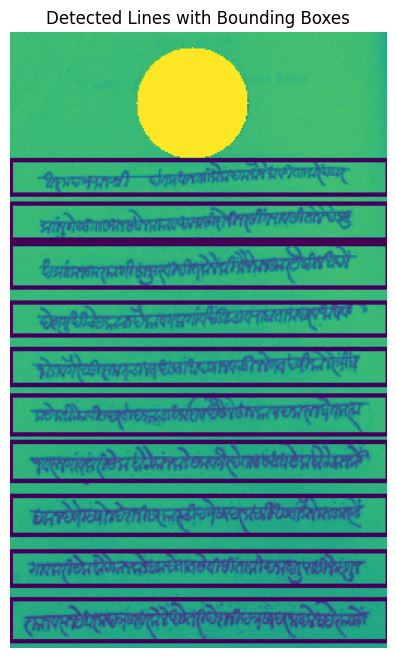

In [4]:
def detect_lines_with_boxes(image, morphed, output_dir="lines_output"):
    gray = image
    contours, hierarchy = cv2.findContours(morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    bboxes = []
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        if w > 40 and h > 10:
            bboxes.append((x, y, w, h))
    bboxes = sorted(bboxes, key=lambda box: box[1])
    boxed_image = image.copy()  
    for (x, y, w, h) in bboxes:
        cv2.rectangle(boxed_image, (x, y), (x + w, y + h), color=(0, 255, 0), thickness=2)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    for i, (x, y, w, h) in enumerate(bboxes, start=1):
        line_crop = image[y:y+h, x:x+w]
        out_path = os.path.join(output_dir, f"line_{i}.png")
        cv2.imwrite(out_path, cv2.cvtColor(line_crop, cv2.COLOR_RGB2BGR))
        print(f"Saved: {out_path}")
    plt.figure(figsize=(10, 8))
    plt.imshow(boxed_image)
    plt.title("Detected Lines with Bounding Boxes")
    plt.axis("off")
    plt.show()
    return boxed_image, bboxes

boxed, boxes = detect_lines_with_boxes(processed_image, morphed)

### Performance Analysis of `detect_lines_with_boxes`

#### Strengths:
1. **Accurate Line Detection**:
   - The use of contours on the morphed image effectively identifies text line boundaries.
   - The bounding boxes are sorted based on the vertical position (`box[1]`), ensuring lines are processed in a top-to-bottom order.

2. **Flexibility in Saving Results**:
   - Each detected line is cropped and saved to the specified output directory, allowing further analysis or processing.

3. **Efficient Bounding Box Creation**:
   - Filters based on width (`w > 40`) and height (`h > 10`) prevent detection of noise or very small artifacts, focusing on significant text lines.

#### Limitations and Failure Cases:
1. **Irregular Text Lines**:
   - For images with skewed or curved text, bounding boxes may not align well, leading to partial or inaccurate detections.

2. **Overlapping or Densely Packed Text**:
   - In cases where text lines are very close, contours may merge, resulting in a single bounding box for multiple lines.

3. **Variable Font Sizes**:
   - The fixed threshold values (`w > 40`, `h > 10`) might fail for smaller fonts or narrow text lines, potentially missing these lines.

4. **Background Noise**:
   - If the morphological transformation retains noise, it may produce false positives in bounding box detection.

5. **Orientation Sensitivity**:
   - This algorithm assumes horizontally aligned text. Non-horizontal text (e.g., rotated or vertical) may not be properly segmented.

6. **Loss of Context in Cropping**:
   - Cropping individual lines can result in the loss of spatial context, which might be critical for downstream tasks like OCR.

# Seal

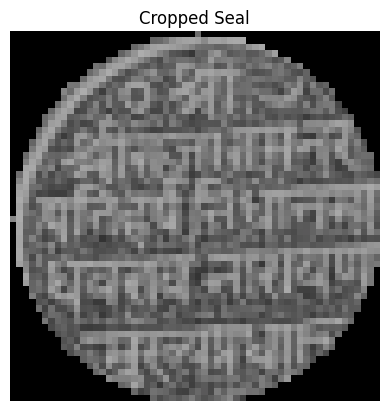

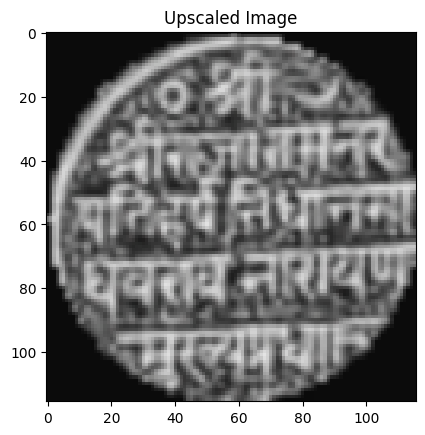

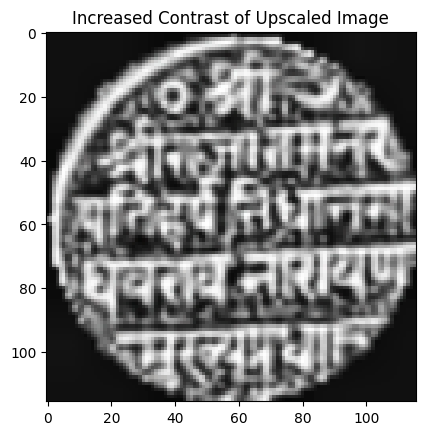

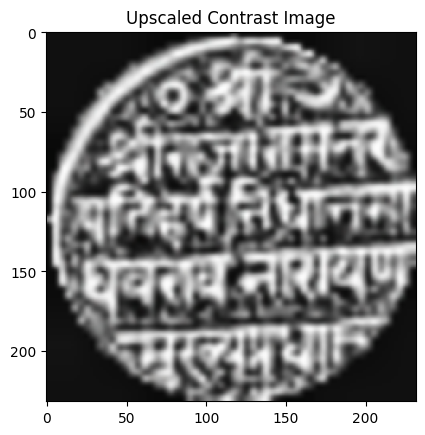

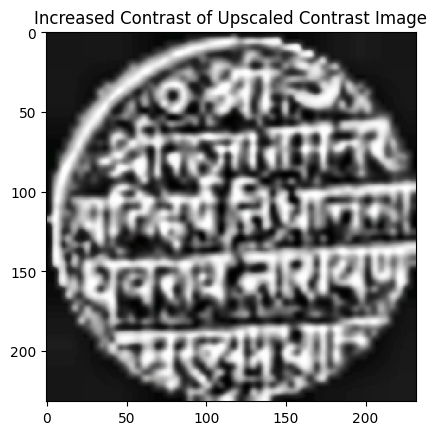

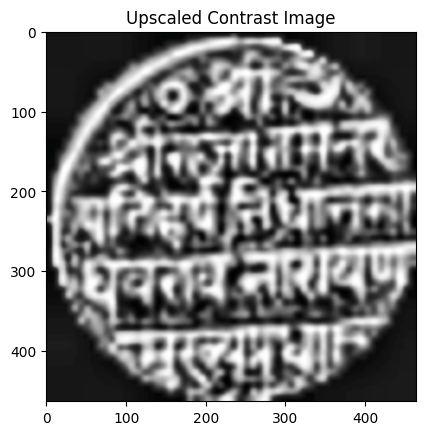

Saved: polynomial_output/seal_1.png
Saved: polynomial_output/seal_2.png
Saved: polynomial_output/seal_3.png
Saved: polynomial_output/seal_4.png
Saved: polynomial_output/seal_5.png
Saved: polynomial_output/seal_6.png
Saved: polynomial_output/seal_7.png
Saved: polynomial_output/seal_8.png
Saved: polynomial_output/seal_9.png
Saved: polynomial_output/seal_10.png
Saved: polynomial_output/seal_11.png
Saved: polynomial_output/seal_12.png
Saved: polynomial_output/seal_13.png
Saved: polynomial_output/seal_14.png
Saved: polynomial_output/seal_15.png
Saved: polynomial_output/seal_16.png
Saved: polynomial_output/seal_17.png
Saved: polynomial_output/seal_18.png
Saved: polynomial_output/seal_19.png
Saved: polynomial_output/seal_20.png
Saved: polynomial_output/seal_21.png
Saved: polynomial_output/seal_22.png
Saved: polynomial_output/seal_23.png
Saved: polynomial_output/seal_24.png
Saved: polynomial_output/seal_25.png
Saved: polynomial_output/seal_26.png
Saved: polynomial_output/seal_27.png
Saved: pol

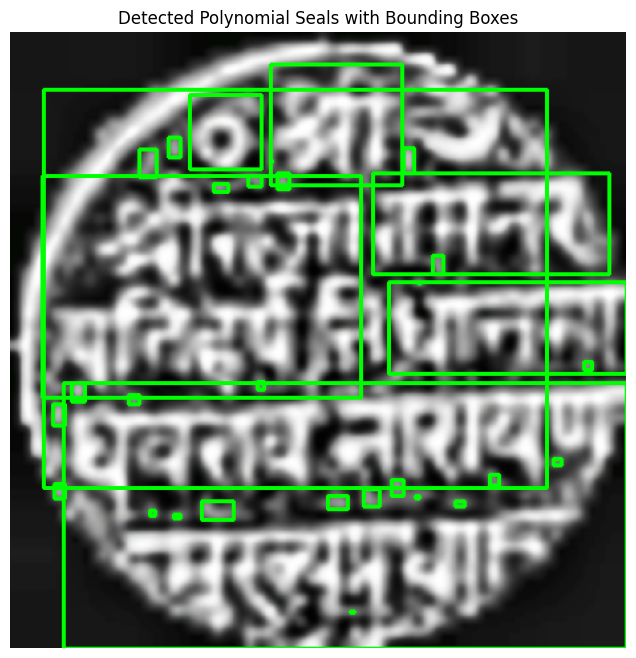

In [131]:
def extract_circular_seal(original_image, seal):
    (cx, cy), radius = seal
    radius -= 8
    if len(original_image.shape) == 2:
        color_img = cv2.cvtColor(original_image, cv2.COLOR_GRAY2BGR)
    else:
        color_img = original_image.copy()
    h, w = color_img.shape[:2]
    x1 = max(cx - radius, 0)
    y1 = max(cy - radius, 0)
    x2 = min(cx + radius, w)
    y2 = min(cy + radius, h)
    seal_crop = color_img[y1:y2, x1:x2].copy()
    mask = np.zeros((y2 - y1, x2 - x1), dtype=np.uint8)
    circle_center = (radius, radius)  
    offset_x = cx - x1
    offset_y = cy - y1
    cv2.circle(mask, (offset_x, offset_y), radius, 255, -1)
    seal_crop[mask == 0] = (0, 0, 0)  
    return seal_crop

cropped_seal = extract_circular_seal(doc_image, seal)
plt.imshow(cv2.cvtColor(cropped_seal, cv2.COLOR_BGR2RGB))
plt.title("Cropped Seal")
plt.axis("off")
plt.show()

def increase_contrast(image):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    return final

contrast = increase_contrast(cropped_seal)
plt.imshow(cv2.cvtColor(contrast, cv2.COLOR_BGR2RGB))
plt.title("Increased Contrast")

def upscale_image(image, scale_percent=200):
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    dim = (width, height)
    resized = cv2.resize(image, dim, interpolation=cv2.INTER_LINEAR)
    return resized

upscaled = upscale_image(contrast)
plt.imshow(cv2.cvtColor(upscaled, cv2.COLOR_BGR2RGB))
plt.title("Upscaled Image")
plt.show()

contrast_upscaled = increase_contrast(upscaled)
plt.imshow(cv2.cvtColor(contrast_upscaled, cv2.COLOR_BGR2RGB))
plt.title("Increased Contrast of Upscaled Image")
plt.show()

upscaled_contrast = upscale_image(contrast_upscaled)
plt.imshow(cv2.cvtColor(upscaled_contrast, cv2.COLOR_BGR2RGB))
plt.title("Upscaled Contrast Image")
plt.show()

contrast_upscaled_contrast = increase_contrast(upscaled_contrast)
plt.imshow(cv2.cvtColor(contrast_upscaled_contrast, cv2.COLOR_BGR2RGB))
plt.title("Increased Contrast of Upscaled Contrast Image")
plt.show()

upscaled_contrast_upscaled_contrast = upscale_image(contrast_upscaled_contrast)
plt.imshow(cv2.cvtColor(upscaled_contrast_upscaled_contrast, cv2.COLOR_BGR2RGB))
plt.title("Upscaled Contrast Image")
plt.show()

def detect_polynomial_seal(image, output_dir="polynomial_output"):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    bboxes = []
    for c in contours:
        epsilon = 0.02 * cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, epsilon, True)
        x, y, w, h = cv2.boundingRect(approx)
        # if len(approx) > 4 and w > 40 and h > 10:
        bboxes.append((x, y, w, h))
    bboxes = sorted(bboxes, key=lambda box: box[1])
    boxed_image = image.copy()
    for (x, y, w, h) in bboxes:
        cv2.rectangle(boxed_image, (x, y), (x + w, y + h), color=(0, 255, 0), thickness=2)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    for i, (x, y, w, h) in enumerate(bboxes, start=1):
        seal_crop = image[y:y+h, x:x+w]
        out_path = os.path.join(output_dir, f"seal_{i}.png")
        cv2.imwrite(out_path, cv2.cvtColor(seal_crop, cv2.COLOR_RGB2BGR))
        print(f"Saved: {out_path}")
    plt.figure(figsize=(10, 8))
    plt.imshow(boxed_image)
    plt.title("Detected Polynomial Seals with Bounding Boxes")
    plt.axis("off")
    plt.show()
    return boxed_image, bboxes

boxed_polynomial, boxes_polynomial = detect_polynomial_seal(upscaled_contrast_upscaled_contrast)

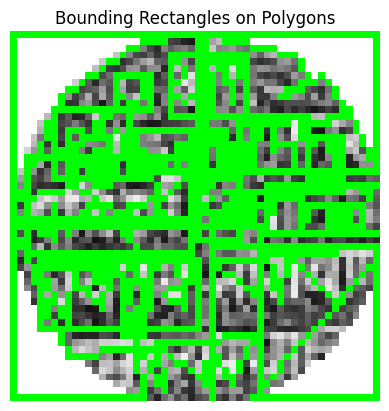

Saved band 1 to polynomial_output/filtered_band_1.png
Saved band 2 to polynomial_output/filtered_band_2.png
Saved band 3 to polynomial_output/filtered_band_3.png
Saved band 4 to polynomial_output/filtered_band_4.png
Saved band 5 to polynomial_output/filtered_band_5.png
Saved band 6 to polynomial_output/filtered_band_6.png


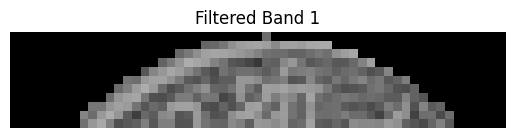

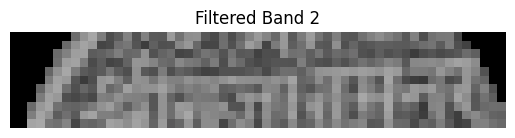

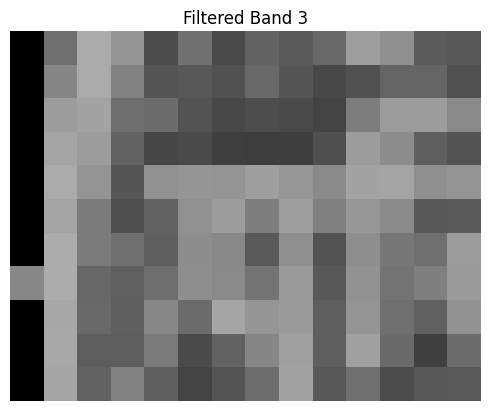

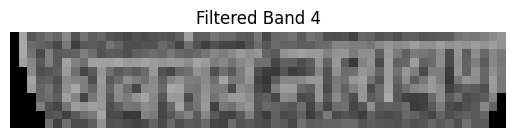

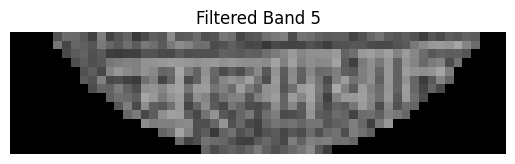

In [135]:
def bounding_rect_polygons(image, polygons):
    bboxes = []
    for poly in polygons:
        x, y, w, h = cv2.boundingRect(poly)
        if h < 2000 and w > 0:
            bboxes.append((x, y, w, h)) 
    bboxes = sorted(bboxes, key=lambda box: box[1])
    boxed_image = image.copy()
    for (x, y, w, h) in bboxes:
        cv2.rectangle(boxed_image, (x, y), (x + w, y + h), color=(0, 255, 0), thickness=1)  # green for visualizing
    plt.imshow(cv2.cvtColor(boxed_image, cv2.COLOR_BGR2RGB))
    plt.title("Bounding Rectangles on Polygons")
    plt.axis("off")
    plt.show()
    return boxed_image, bboxes

boxed_polygons, boxes_polygons = bounding_rect_polygons(polygons_image, polygons)
image = cropped_seal  
filter_and_save(image, boxed_polygons, boxes_polygons)
filtered_images = []
for i in range(1, 6):
    path = f"polynomial_output/filtered_band_{i}.png"
    img = cv2.imread(path)
    filtered_images.append(img)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"Filtered Band {i}")
    plt.axis("off")
    plt.show()


# Challenges of Segmenting the Lines Inside the Seal Compared to the Main Document

### Key Challenges

#### 1. **Circular Nature of Seals**
   - **Main Document:** Lines are typically arranged in horizontal or vertical patterns, making them easier to detect using standard algorithms.
   - **Seal:** The lines are arranged within in a circular pattern, requiring specialized techniques like circular cropping and masks.

#### 2. **High Noise and Overlapping Features**
   - **Main Document:** Text is generally well-separated and printed on a clean background, reducing noise.
   - **Seal:** Contains intricate designs, that overlap with the text, increasing segmentation difficulty.

#### 3. **Variable Contrast**
   - **Main Document:** Uniform contrast and consistent lighting make text extraction straightforward.
   - **Seal:** Uneven ink distribution and variations in the seal's texture lead to inconsistent contrast.

#### 4. **Scale and Resolution**
   - **Main Document:** Text is often larger and spaced for readability.
   - **Seal:** Text is smaller and compressed, making it harder to distinguish between fine details.

#### 5. **Blend with Background**
   - **Main Document:** Text often has a distinct color and contrast from the background.
   - **Seal:** Seal boundaries blur into the background, complicating segmentation.

### Techniques Used 

1. **Circular Seal Extraction**
   - A circular mask is applied to isolate the seal from the rest of the document.

2. **Contrast Enhancement**
   - The `increase_contrast` function improves visibility of features inside the seal.

3. **Image Upscaling**
   - Upscaling is applied to improve resolution for better segmentation.

4. **Polygon Approximation**
   - Contours are approximated concatinated on the image (light grey thin contours)

5. **Bounding Box Detection**
   - Bounding boxes are used to identify and isolate potential regions of text within the seal.

# Polynomial

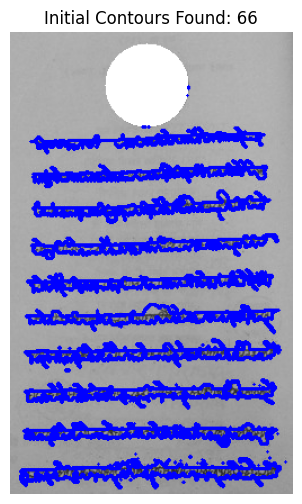

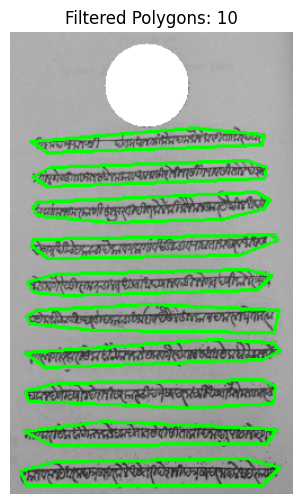

In [5]:
def detect_lines_with_polygons(image, morphed, output_dir="polygon_lines_output"):
    contours, _ = cv2.findContours(morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    debug_image = image.copy()
    if len(debug_image.shape) == 2:
        debug_image = cv2.cvtColor(debug_image, cv2.COLOR_GRAY2RGB)
    cv2.drawContours(debug_image, contours, -1, (0, 0, 255), 2)
    plt.figure(figsize=(12, 6))
    plt.imshow(debug_image)
    plt.title(f"Initial Contours Found: {len(contours)}")
    plt.axis('off')
    plt.show()
    result_image = image.copy()
    if len(result_image.shape) == 2:
        result_image = cv2.cvtColor(result_image, cv2.COLOR_GRAY2RGB)
    line_polygons = []
    for contour in contours:
        if cv2.contourArea(contour) < 20:  
            continue
        hull = cv2.convexHull(contour)
        rect = cv2.minAreaRect(hull)
        width = min(rect[1])
        height = max(rect[1])
        epsilon = 0.01 * cv2.arcLength(hull, True)  
        simplified_polygon = cv2.approxPolyDP(hull, epsilon, True)
        line_polygons.append(simplified_polygon)
    if line_polygons:
        line_polygons = sorted(line_polygons, key=lambda p: np.min(p[:, :, 1]))
    debug_filtered = image.copy()
    if len(debug_filtered.shape) == 2:
        debug_filtered = cv2.cvtColor(debug_filtered, cv2.COLOR_GRAY2RGB)
    for polygon in line_polygons:
        cv2.polylines(debug_filtered, [polygon], True, (0, 255, 0), 2)
    plt.figure(figsize=(12, 6))
    plt.imshow(debug_filtered)
    plt.title(f"Filtered Polygons: {len(line_polygons)}")
    plt.axis('off')
    plt.show()
    return result_image, line_polygons

x, y = detect_lines_with_polygons(processed_image, thresh_inv)

### Comparison of Polygonal and Rectangular Bounding Boxes

#### **Advantages of Polygons**:
1. **Precision**:
   - Polygons closely follow the contours of text lines, capturing irregularities and skew, as seen in the second image. 
   - They provide a more accurate representation of text boundaries, especially for rotated or curved lines.

2. **Flexibility**:
   - Polygons adapt to non-rectangular shapes, handling text that deviates from horizontal alignment or has varying line lengths.

3. **Reduced Noise Inclusion**:
   - By approximating the contour, polygons avoid including large areas of blank space within the bounding regions, unlike rectangles.

#### **Disadvantages of Polygons**:
1. **Complexity**:
   - Polygon generation involves additional computational steps (e.g., `cv2.convexHull` and `cv2.approxPolyDP`), increasing processing time.
   - Storing and processing polygonal coordinates require more memory and effort compared to simpler rectangular coordinates.

2. **Over-Fitting**:
   - If the contour simplification (`epsilon`) is too low, the polygon may overfit noise or artifacts, capturing irrelevant details.

3. **Difficulty in Downstream Processing**:
   - OCR systems often prefer rectangular bounding boxes. Using polygons may require preprocessing to map the text into a rectangular form.

### Impact of Polygon Detection Method
1. **Strengths**:
   - The method effectively filters out small contours (`cv2.contourArea`) and simplifies contours using `cv2.approxPolyDP`, making it robust against noise.
   - Sorting polygons based on vertical coordinates ensures proper sequential text line extraction.

2. **Weaknesses**:
   - The simplification parameter (`epsilon`) must be carefully chosen; too small leads to overfitting, and too large causes loss of detail.
   - The convex hull operation (`cv2.convexHull`) may smooth out significant details for highly irregular text contours.

### Conclusion
- **Rectangles**: Best for straightforward, horizontal text where simplicity and speed are priorities.
- **Polygons**: Ideal for complex, irregularly shaped text but add computational overhead and complexity to downstream tasks.